# KNN Regression and Classification

## Regression First

- Let's generate some synthetic data, and test out KNN regression
- Visualize bias-variance tradeoff
- Do basic hyperparameter tuning on $k$ (`n_neighbors`)


In [1]:
#Some libraries
#####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

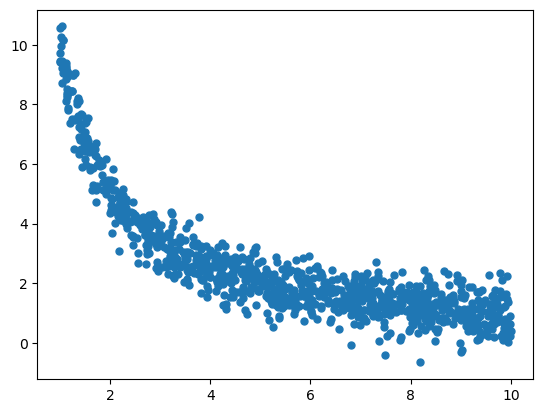

In [2]:
#First, let's create some synthetic data
N = 1000

#Random points between 0 and 10, sorted:
x = np.random.uniform(1, 10, N)
x.sort()

#Nonlinear equation:
#y = 10/x + .5*x + .1*x**1.5 + 5/x*np.sin(x*2) + np.random.normal(loc=0, scale=.5, size=N)

y = 10/x + np.random.normal(loc=0, scale=.5, size=N)

#Put in a DataFrame:
df = pd.DataFrame({'X':x, 'y':y})

#Plot our "data":
plt.plot(df.X, df.y, 'o', markersize=5)

#### Test/Train Split + Scaling

- Scaling not really necessary for single feature, but let's do it anyway

In [3]:
from sklearn.model_selection import train_test_split

#Use scikit learn for the split:
#Note we use X[['X']]
X_train, X_test, y_train, y_test = train_test_split(df[['X']], df[['y']], test_size=.5, random_state=42)

In [4]:
## And standard scaler:
#####
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

#Fit-transform
X_train_scaled = std_scaler.fit_transform(X_train)

#And transform testing:
X_test_scaled = std_scaler.transform(X_test)


#Back to DataFrame:
X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns,
                              index = X_train.index)

#Back to DataFrame:
X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns,
                              index = X_test.index)
X_train

,X
680,0.581870
177,-1.137347
395,-0.387621
911,1.347181
793,0.956345
...,...
106,-1.435128
270,-0.811230
860,1.155953
435,-0.254251


### Try out some regressors

- We'll try different `n_neighbors`
- Plot performance train vs. cross-validated
- Compare RMSE for train data vs. cross-validated train data

#### Important:

- *In this dataset it matters a lot if we shuffle our folds!*
- We'll use `KFold` from scikit-learn to generate these folds

In [5]:
#Import the estimator, etc:
####

from sklearn.neighbors import KNeighborsRegressor

#And we'll need these:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
    
#And this:
from sklearn.metrics import mean_squared_error

In [6]:
#Let's sort the data, for plotting purposes:
X_train = X_train.sort_values(by='X')

print(X_train.head())
#And line y_train up with X:
y_train = y_train.loc[X_train.index]

print(y_train.head())

           X
1  -1.796766
4  -1.793679
8  -1.782892
13 -1.776066
14 -1.775906
           y
1   9.410749
4   9.971313
8   8.718513
13  9.059454
14  9.224711


In [7]:
#Also, sort testing:
X_test = X_test.sort_values(by='X')
y_test = y_test.loc[X_test.index]

### Try out `Kfold`:

- See also `StratifiedKFold`

In [8]:
#Make the object:
#shuffle=False is default:
n_folds = 5
kfolder = KFold(n_splits = n_folds, shuffle = False)

#Now make a split:
#This is a generator:
ksplit = kfolder.split(X_train, y_train)
ksplit

<generator object _BaseKFold.split at 0x000002840801FA70>

In [9]:
#Examine a single fold
#Get indices for training and testing

train_index, test_index = next(ksplit)

print(train_index)
print('\n', test_index)

[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 339 340 341 342 343 344 345 34

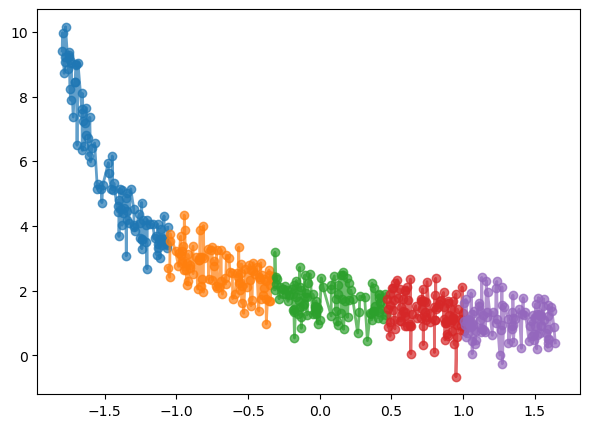

In [10]:
## We can use next to step through the generator:
#Re-make our generator
n_folds = 5
do_shuffle = False
kfolder = KFold(n_splits = n_folds, shuffle = do_shuffle)
ksplit = kfolder.split(X_train, y_train)


#And go through the folds:
fig1, ax1 = plt.subplots(1, 1, figsize=(7,5))

#Let's plot our folds: We'll plot the *testing* indices
for n in range(n_folds):
    train_index, test_index = next(ksplit)
    
    
    #Do line vs scatter plot based on do_shuffle:
    if (not do_shuffle):
        ax1.plot(X_train.iloc[test_index], y_train.iloc[test_index], '-o', label=str('fold = ' + str(n)), linewidth=2, alpha=.7)
    else:
        ax1.scatter(X_train.iloc[test_index], y_train.iloc[test_index], label=str('fold = ' + str(n)), s=20, alpha=.7)

### Now, Model Performance as a Function of `n_neighbors`

- Training vs. cross-validation
- Compare shuffled vs. unshuffled folds
- Also, compared leave-one-out (LOO) cross-validation

1.7101561354644044 1.7101561354644046
1.610037261671505 1.610037261671505
1.5389659217131038 1.5389659217131038
1.5325929093624036 1.5325929093624033
1.607787836777474 1.607787836777474
1.737361900155264 1.7373619001552643


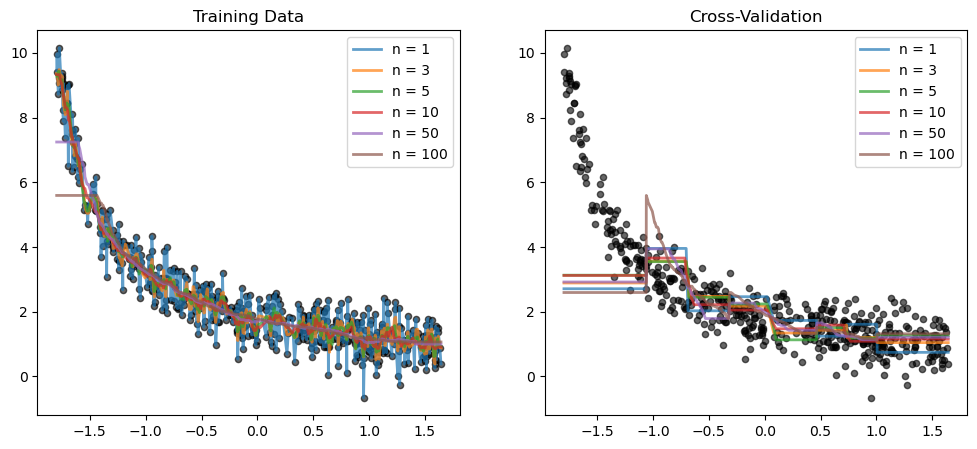

In [11]:
## Let's loop:

#Empty DataFrame to store results:
df_rmse = pd.DataFrame(columns=['RMSE_train', 'RMSE_CV', 'n'])


fig1, ax1 = plt.subplots(1, 2, figsize=(12,5))

#Plot the data:
####
[ax1[i].scatter(X_train['X'], y_train['y'], s=20, color='black', alpha=.6) for i in range(2)]

    
for n in [1, 3, 5, 10, 50, 100]:

    knn = KNeighborsRegressor(n_neighbors=n)
    
    #Fit the model:
    knn.fit(X_train, y_train)
    
    #Get predictions on training data:
    y_train_pred = knn.predict(X_train)
    
    #Get pridctions using cross-validation:
    ## Either use KFold:
    if (1):
        #Can add random_state=42 to KFold for reproducibility under shuffling
        y_cv_pred = cross_val_predict(knn, X_train, y_train, cv=KFold(n_splits=5, shuffle=False)) #len(X_train)-1)
    else:
        #Or use LOO cross-validation:
        y_cv_pred = cross_val_predict(knn, X_train, y_train, len(X_train)-1)

    #And plot:
    ax1[0].plot(X_train['X'], y_train_pred, label=str('n = ' + str(n)), linewidth=2, alpha=.7)
    ax1[1].plot(X_train['X'], y_cv_pred, label=str('n = ' + str(n)), linewidth=2, alpha=.7)
    
    

    #Also, store the RMSEs:
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_cv = mean_squared_error(y_train, y_cv_pred, squared=False)
    
    #Can also get RMSEs like so:
    #Note the following: We get the neg_mean_squared_error as our scoring function
    #Then, we take the mean, and finally take the square root; Taking the mean of the RMSE across folds is incorrect
    rmse_cv_2 = -cross_val_score(knn, X_train, y_train,
                              scoring="neg_mean_squared_error", cv=KFold(n_splits=5, shuffle=False))
    
    #Compare the two methods:
    print(rmse_cv, np.sqrt(np.mean(rmse_cv_2)))
    
    #Add to the DataFrame
    df_rmse = pd.concat((df_rmse, pd.DataFrame({'RMSE_train':rmse_train, 'RMSE_CV':rmse_cv, 'n':[n]})), ignore_index=True)
    
    
#Finally, some plotting stuff
[ax1[i].legend() for i in range(2)];

ax1[0].set_title('Training Data')
ax1[1].set_title('Cross-Validation');

In [12]:
#How do our RMSEs look?
#######

df_rmse

,RMSE_train,RMSE_CV,n
0,0.000000,1.710156,1
1,0.437868,1.610037,3
2,0.468304,1.538966,5
3,0.496178,1.532593,10
4,0.619430,1.607788,50
5,0.884615,1.737362,100


### Add in Standard Devation

In [13]:
## Let's loop:

#Can check against MAE...

#Empty DataFrame to store results:
df_rmse = pd.DataFrame(columns=['RMSE_train', 'RMSE_test', 'RMSE_CV', 'RMSE_CV_std', 'n'])
    
for n in range(1,100):

    knn = KNeighborsRegressor(n_neighbors=n)
    
    #Fit the model:
    knn.fit(X_train, y_train)
    
    #Get predictions on training data:
    y_train_pred = knn.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    
    #Throw in predictions on the test data too!
    y_test_pred = knn.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    
    
    #Can also get RMSEs like so:
    #Note the following: We get the neg_mean_squared_error as our scoring function
    #Then, we take the mean, and finally take the square root; Taking the mean of the RMSE across folds is incorrect
    rmse_cv = -cross_val_score(knn, X_train, y_train,
                              scoring="neg_mean_squared_error", cv=KFold(n_splits=5, shuffle=True))
    
    #Add to the DataFrame
    df_rmse = pd.concat((df_rmse, pd.DataFrame({'RMSE_train':rmse_train, 'RMSE_test':rmse_test,
                                                'RMSE_CV':np.sqrt(np.mean(rmse_cv)),
                                                'RMSE_CV_std':np.std(np.sqrt(rmse_cv)), 'n':[n]})), ignore_index=True)
    
    #df_rmse = pd.concat((df_rmse, pd.DataFrame({'RMSE_train':rmse_train, 'RMSE_test':rmse_test,
    #                                            'RMSE_CV':np.mean(rmse_cv),
    #                                            'RMSE_CV_std':np.std(rmse_cv), 'n':[n]})), ignore_index=True)
                        
df_rmse.n = df_rmse.n.astype(int)

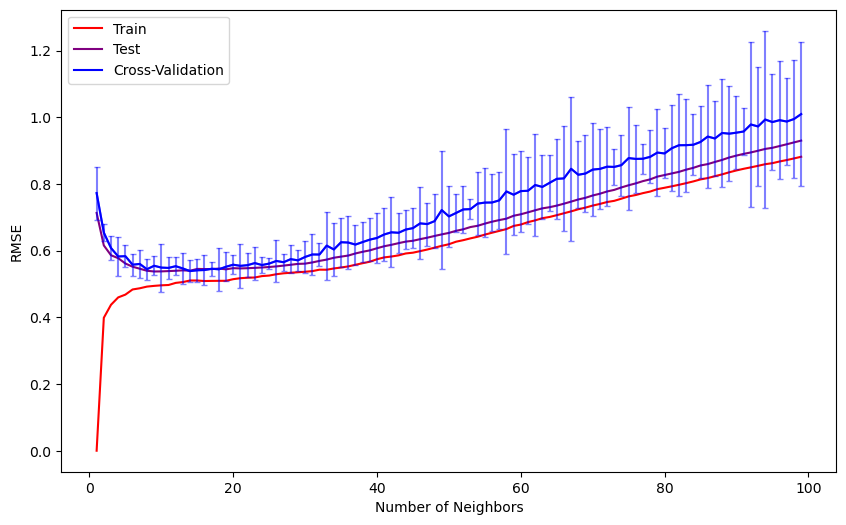

In [14]:
#Plot with std deviations
fig1, ax1 = plt.subplots(1, 1, figsize=(10,6))

#RMSE on the train alone
ax1.plot(df_rmse.n, df_rmse.RMSE_train, color='red', label='Train')

#Test:
ax1.plot(df_rmse.n, df_rmse.RMSE_test, color='purple', label='Test')

#On the Cross-validation sets
ax1.plot(df_rmse.n, df_rmse.RMSE_CV, color='blue', label='Cross-Validation')

ax1.errorbar(df_rmse.n, df_rmse.RMSE_CV, df_rmse.RMSE_CV_std, alpha=.5, capsize=2, color='blue')


ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('RMSE')

ax1.legend()

0.49617828527564445 0.5380015338786855


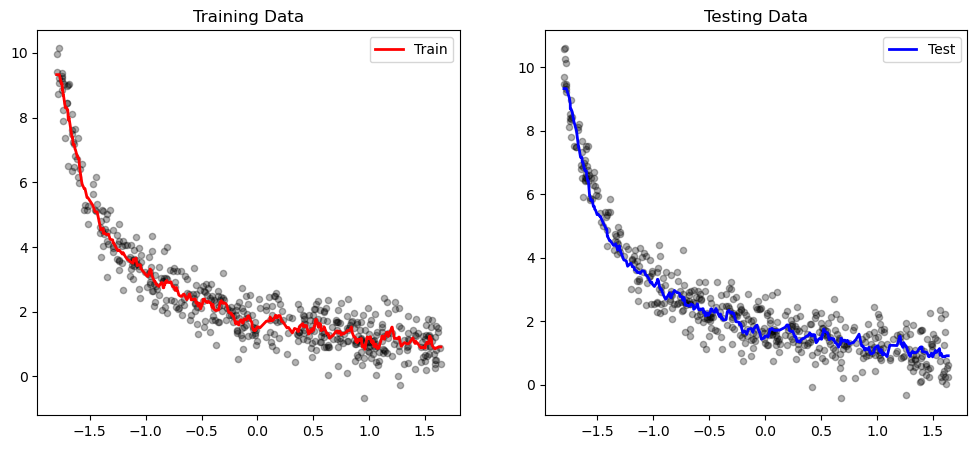

In [15]:
## Results on Train/Test for given n:

#Can get rid of initial and ending transients:
######
min_index_train = 0; max_index_train = len(X_train)
min_index_test = 0; max_index_test = len(X_test)

fig1, ax1 = plt.subplots(1, 2, figsize=(12,5))

#Plot the data:
####
ax1[0].scatter(X_train['X'], y_train['y'], s=20, color='black', alpha=.3)
ax1[1].scatter(X_test['X'], y_test['y'], s=20, color='black', alpha=.3)

n = 10

knn = KNeighborsRegressor(n_neighbors=n)
    
#Fit the model:
knn.fit(X_train, y_train)
    
#Get predictions on training data:
y_train_pred = knn.predict(X_train)
rmse_train = mean_squared_error(y_train.iloc[min_index_train:max_index_train], y_train_pred[min_index_train:max_index_train], squared=False)

#Throw in predictions on the test data too!
y_test_pred = knn.predict(X_test)
rmse_test = mean_squared_error(y_test.iloc[min_index_test:max_index_test], y_test_pred[min_index_test:max_index_test], squared=False)


#RMSE on the train alone
ax1[0].plot(X_train.X.iloc[min_index_train:max_index_train], y_train_pred[min_index_train:max_index_train],
            color='red', linewidth=2, label='Train')

#Test:
ax1[1].plot(X_test.X.iloc[min_index_test:max_index_test], y_test_pred[min_index_test:max_index_test],
            color='blue', linewidth=2, label='Test')


#Finally, some plotting stuff
[ax1[i].legend() for i in range(2)];

ax1[0].set_title('Training Data')
ax1[1].set_title('Testing Data');


print(rmse_train, rmse_test)

### Use `GridSearchCV`

Let's use Scikit-Learn's `GridSearchCV`...

In [16]:
## Grab it and use it
from sklearn.model_selection import GridSearchCV


#Parameters dictionary:
parameters = {'n_neighbors': range(1, 100, 1)}

#Model
knn = KNeighborsRegressor(n_neighbors=n)

#Grid search: Note we use KFold
#Create it
grid_search = GridSearchCV(knn, parameters, cv=KFold(n_splits=5, shuffle=True),
                          scoring="neg_mean_squared_error")

#And fit it:
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsRegressor(n_neighbors=10),
             param_grid={'n_neighbors': range(1, 100)},
             scoring='neg_mean_squared_error')

In [17]:
#Look at all our results:
#####

grid_search.cv_results_

{'mean_fit_time': array([0.00180016, 0.0018002 , 0.00200047, 0.00180058, 0.00200062,
        0.00180039, 0.00200047, 0.0018003 , 0.00160041, 0.00180044,
        0.00180025, 0.00160046, 0.00180054, 0.00180016, 0.00180073,
        0.00160027, 0.00160055, 0.00160041, 0.00180058, 0.00160022,
        0.00200109, 0.00150485, 0.00170345, 0.00160027, 0.00180025,
        0.0016006 , 0.00160022, 0.0018003 , 0.00160055, 0.00160046,
        0.00180054, 0.00159984, 0.00180063, 0.00200071, 0.00139976,
        0.00180106, 0.00160046, 0.00200047, 0.00160017, 0.00140014,
        0.00200038, 0.00160027, 0.00160036, 0.00200028, 0.0012002 ,
        0.00180058, 0.00200005, 0.00200033, 0.00160036, 0.00180068,
        0.00160022, 0.00200028, 0.00200024, 0.00200028, 0.00200062,
        0.00160036, 0.00100036, 0.00160031, 0.00160031, 0.00200062,
        0.00200033, 0.00180016, 0.00200038, 0.00230079, 0.00200033,
        0.00200405, 0.00179353, 0.0018002 , 0.00200019, 0.00180087,
        0.00179558, 0.00180044,

Text(0, 0.5, 'RMSE')

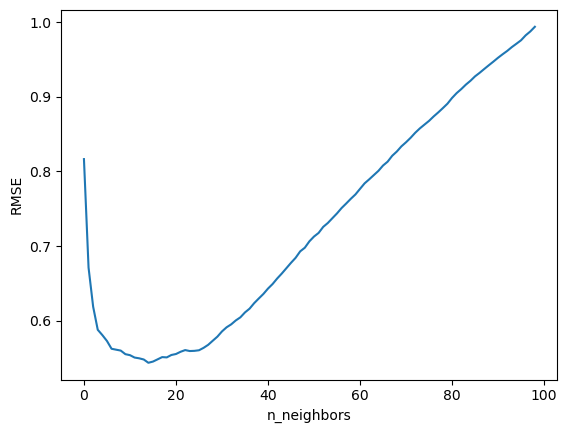

In [18]:
#Plot the mean score as function of n
plt.plot(np.sqrt(-grid_search.cv_results_['mean_test_score']))

plt.xlabel('n_neighbors')
plt.ylabel('RMSE')

## And Classification

- Let's generate more synthetic data, using an underlying logistic regression model

- Logistic regression give the log odds of belonging to a class as a linear function of the predictors

- Quick GridSearchCV and plot of predictor surface

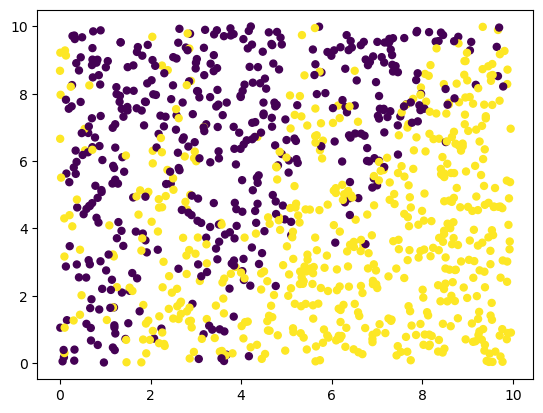

In [19]:
#Synthetic data with two features this time
########

N = 1000

#Random points between 0 and 10, sorted:
x1 = np.random.uniform(0, 10, N)
x2 = np.random.uniform(0, 10, N)

#Nonlinear equation:
#y = 10/x + .5*x + .1*x**1.5 + 5/x*np.sin(x*2) + np.random.normal(loc=0, scale=.5, size=N)

log_odds = x1**2 - x1*x2 - 10*np.sin(x1*2) + np.random.normal(loc=0, scale=10, size=N)
odds = np.exp(log_odds)

p = odds / (odds + 1)

y = (p > .5).astype(int)

#Put in a DataFrame:
df_clf = pd.DataFrame({'X1':x1, 'X2':x2, 'y':y})

#Plot our "data":
plt.scatter(df_clf.X1, df_clf.X2, c=df_clf.y, s=25);

In [20]:
## Good ole' test/train split
#########
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(df_clf[['X1', 'X2']], df_clf['y'], test_size=.5, random_state=42)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

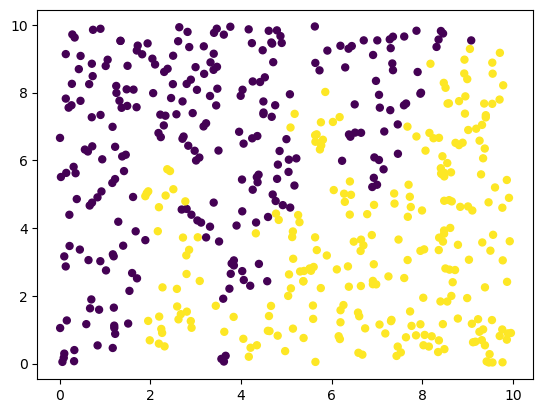

In [22]:
#Fit the model:
knn_clf.fit(X_train_clf, y_train_clf)

#Get predictions on training data:
y_train_pred = knn_clf.predict(X_train_clf)

plt.scatter(X_train_clf.X1, X_train_clf.X2, c=y_train_pred, s=25);


In [23]:
## Grab it and use it
from sklearn.model_selection import GridSearchCV


#Parameters dictionary:
parameters = {'n_neighbors': range(1, 200, 1)}

#Model
knn_clf = KNeighborsClassifier()

#Grid search: Note we use KFold
#Create it
grid_search = GridSearchCV(knn_clf, parameters, cv=KFold(n_splits=10, shuffle=True),
                          scoring="accuracy")

#And fit it:
grid_search.fit(X_train_clf, y_train_clf)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 200)}, scoring='accuracy')

Text(0, 0.5, 'Accuracy')

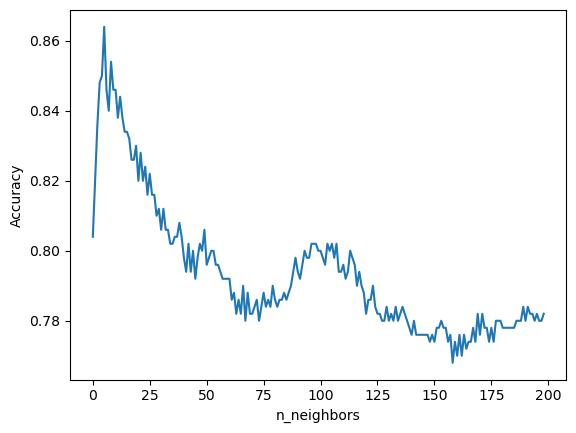

In [24]:
#Quick Plot
#####3

plt.plot(grid_search.cv_results_['mean_test_score']);

plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')

In [25]:
#Best Param?
grid_search.best_params_

{'n_neighbors': 6}

In [26]:
##Set k = grid_search.best_params_
knn_clf = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_clf.fit(X_train_clf, y_train_clf)

KNeighborsClassifier(n_neighbors=6)

In [27]:
#Range for contour:
x1 = 0; x2 = np.max(X_train_clf.X1)*1.025
y1 = 0; y2 = np.max(X_train_clf.X2)*1.025

#Points for contour
N = 75

X, Y = np.meshgrid(np.linspace(x1, x2, 200),
                         np.linspace(y1, y2, 200))

#Get as Nx2:
XY_ravel = np.c_[X.ravel(), Y.ravel()]


#Get the class:
Z = knn_clf.predict(XY_ravel)

#Reshape back:
Z = Z.reshape(X.shape)

C:\Users\steff\Anaconda3\envs\ML_environment\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


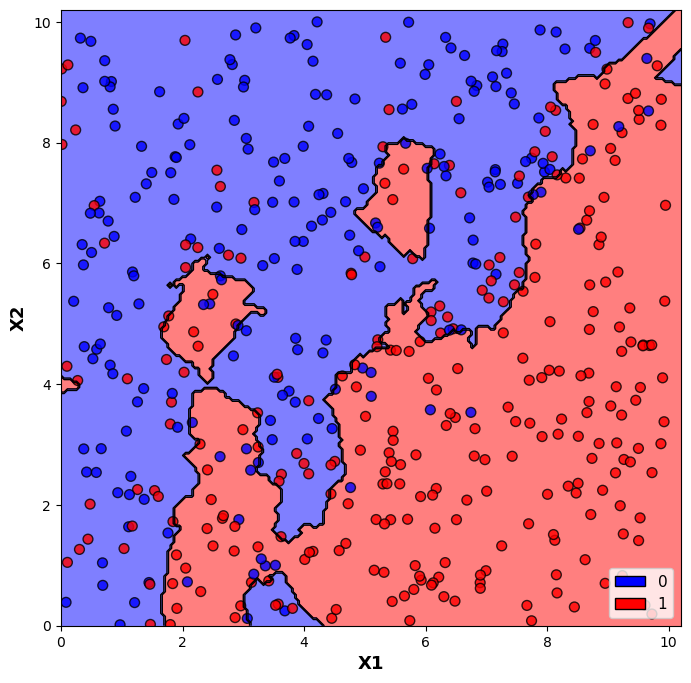

In [28]:
## And plot:
###
from matplotlib.colors import ListedColormap
my_cmap = (ListedColormap(["blue", "red"]))

fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))

ax1.contourf(X, Y, Z, 1, alpha=.5, cmap=my_cmap)
ax1.contour(X, Y, Z, 1, alpha=1, linewidths=1, colors='black')

ax1.scatter(X_test_clf.iloc[:, 0], X_test_clf.iloc[:, 1], c = y_test_clf, cmap=my_cmap, alpha=.8, s=50, edgecolor='black')

ax1.set_xlabel('X1', fontweight='bold', fontsize=13)
ax1.set_ylabel('X2', fontweight='bold', fontsize=13)


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', edgecolor='black', alpha=1, label='0'),
                   Patch(facecolor='red', edgecolor='black', alpha=1, label='1')]

ax1.legend(handles=legend_elements, fontsize=11, loc='lower right');